In [1]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display,Image
from typing_extensions import TypedDict

In [2]:
from langchain_ollama import ChatOllama
from typing import Annotated,List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

llm = ChatOllama(model = 'llama3.2')

In [3]:
class AgentState(TypedDict):
     messages: Annotated[List[BaseMessage], add_messages]

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_tavily import TavilyExtract,TavilySearch

# print(dir(TavilyMap))
# for i in dir(TavilyMap):
#     print(i,"\n\n")
#     print(i.__doc__)
#     print("----"*20)

In [6]:
# tool = TavilySearch()
# tool.invoke("search for the picnic placs from Hyderabad. my budget is under 5000/- and i like hilly areas")

In [7]:
tavily_tool = TavilySearch(max_results=5) # Limit results to 5 for conciseness
tools = [tavily_tool]

place_search_agent = llm.bind_tools(tools)

In [8]:
from langgraph.prebuilt import ToolNode

def call_model(state: AgentState):
    """This function is used to search for places from the web using Tavily API Key
    """
    messages = state["messages"]
    response = place_search_agent.invoke(messages)
    return {"messages": [response]}

# Node to execute tools
tool_node = ToolNode(tools)

In [9]:
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM output a tool call, then we run the tool node
    if last_message.tool_calls:
        print("--- DEBUG: LLM requested tool call ---")
        return "call_tool"
    # Otherwise, it's a direct response from the LLM, so we end
    print("--- DEBUG: LLM provided final answer ---")
    return "end"

In [14]:
graph = StateGraph(AgentState)

# Add nodes to the graph
graph.add_node("llm", call_model)
graph.add_node("call_tool", tool_node)

# Set the entry point of the graph
graph.set_entry_point("llm")

# Define edges
# From the LLM node, conditionally transition based on whether a tool call was made
graph.add_conditional_edges(
    "llm",
    should_continue,
    {"call_tool": "call_tool", "end": END} # <-- Changed END: END to "end": END
)

# After a tool is called, the output should go back to the LLM for processing
graph.add_edge("call_tool", "llm")

# Compile the graph
app = graph.compile()

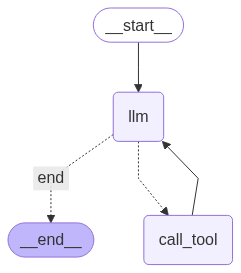

In [15]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
app.invoke(
    {
        'messages':[
            HumanMessage(content="I am getting bored and i want to go on picnic. I am in Hyd and my budget is Rs.5000/-. i like hilly areas.")
        ]
    }
)

--- DEBUG: LLM requested tool call ---


In [ ]:
app.invoke({'messages':['Hi ! i am kalyan']})

--- DEBUG: LLM requested tool call ---
